In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import numpy
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
predOmnPrflDF = pandas.read_csv("../data/omn_cplng_profile_cat.csv", index_col=0)
predOmnPrflDF["newell"] =  -1**(4/3)*numpy.power(numpy.abs(predOmnPrflDF["Vx"]),4./3) * numpy.power(predOmnPrflDF["B_T"], (2./3)) * (numpy.sin(predOmnPrflDF["theta_c"] / 2.))**(8./3)
predOmnPrflDF["ByMagn"] = numpy.abs(predOmnPrflDF["By"])
predOmnPrflDF.head()

,Bz,Vx,By,delTimeOnset,pred_date,pred_type,theta_c,B_T,newell,ByMagn
0,-4.18,-471.6,-0.10,-108.0,2015-01-27 22:50:00,TP,3.163185,4.181196,-9525.722287,0.10
1,-4.00,-471.6,-1.09,-107.0,2015-01-27 22:50:00,TP,3.403185,4.145853,-9259.189012,1.09
2,-3.67,-472.8,-2.03,-106.0,2015-01-27 22:50:00,TP,3.643185,4.194020,-8800.616768,2.03
3,-4.78,-478.8,-1.25,-105.0,2015-01-27 22:50:00,TP,3.393185,4.940739,-10638.467386,1.25
4,-4.64,-478.8,-1.19,-104.0,2015-01-27 22:50:00,TP,3.393185,4.790167,-10421.212211,1.19


In [3]:
meanParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "newell","ByMagn","delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).mean().reset_index()
meanParamDF.columns = ["delTimeOnset", "pred_type", "mean_Bz", "mean_Vx",\
                       "mean_By", "mean_newell","mean_ByMagn"]
stdParamDF = predOmnPrflDF[\
                    ["Bz", "Vx", "By", "newell","ByMagn", "delTimeOnset", "pred_type"]\
                    ].groupby( ["delTimeOnset", "pred_type"] ).std().reset_index()
stdParamDF.columns = ["delTimeOnset", "pred_type", "std_Bz", "std_Vx",\
                      "std_By", "std_newell","std_ByMagn"]
meanParamDF = pandas.merge( meanParamDF, stdParamDF, on=["delTimeOnset", "pred_type"] )
meanParamDF.head()

,delTimeOnset,pred_type,mean_Bz,mean_Vx,mean_By,mean_newell,mean_ByMagn,std_Bz,std_Vx,std_By,std_newell,std_ByMagn
0,-120.0,FN,-0.094075,-425.697583,0.097218,-3375.135394,2.995284,2.737739,81.498419,3.797702,2982.187490,2.336354
1,-120.0,FP,-0.936080,-495.462302,0.699968,-5612.707850,3.521862,3.616415,101.988021,4.444634,4760.894143,2.800019
2,-120.0,TN,0.576982,-394.401163,0.023524,-2587.279346,2.961589,2.947879,71.415640,3.697742,2483.556390,2.214126
3,-120.0,TP,-0.897667,-524.128803,0.974046,-6166.955677,3.587553,4.215549,105.177770,4.585725,5547.202352,3.017729
4,-119.0,FN,-0.128501,-425.998936,0.037751,-3443.618767,3.059921,2.744274,81.425284,3.877248,3032.483490,2.381083


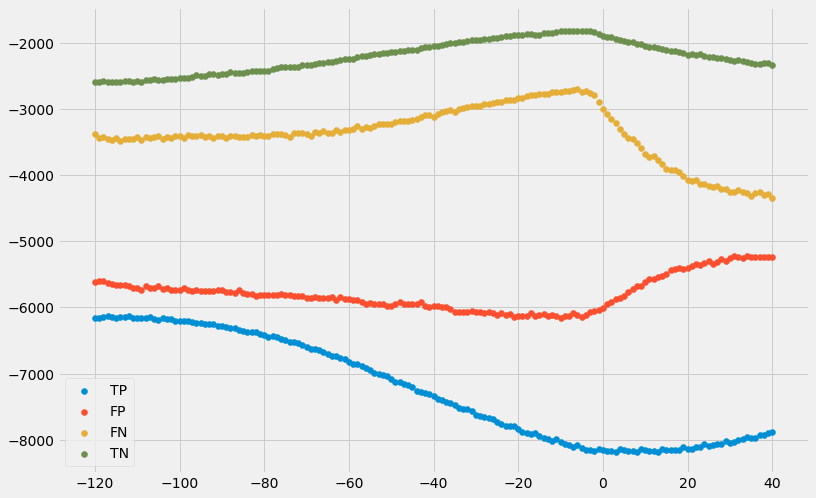

In [4]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

for _pd in predTypeList:
    selDF = meanParamDF[ meanParamDF["pred_type"] == _pd ]
    ax.scatter( selDF["delTimeOnset"].values, selDF["mean_newell"].values, label=_pd )
#     ax.errorbar( selDF["delTimeOnset"].values, selDF["mean_Bz"].values,\
#                yerr=selDF["std_Bz"].values, label='', capthick=2., capsize=5., fmt='o')
plt.legend()
f.savefig("../plots/epoch_pred_types_Bz_mean.pdf")
f.savefig("../plots/epoch_pred_types_Bz_mean.eps")

In [5]:
# Bin by delTBins
delTBins = range(-120,10,10)
print delTBins
# get the min al in the next 30 min
oldColNames = predOmnPrflDF.columns.tolist()
predDF2 = pandas.concat( [ predOmnPrflDF, \
                    pandas.cut( predOmnPrflDF["delTimeOnset"], \
                               bins=delTBins ) ], axis=1 )
predDF2.columns = oldColNames + ["delT_bin"]
predDF2 = predDF2[ predDF2["pred_type"].isin([ "TP", "FP", "FN", "TN"]) ]

[-120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0]


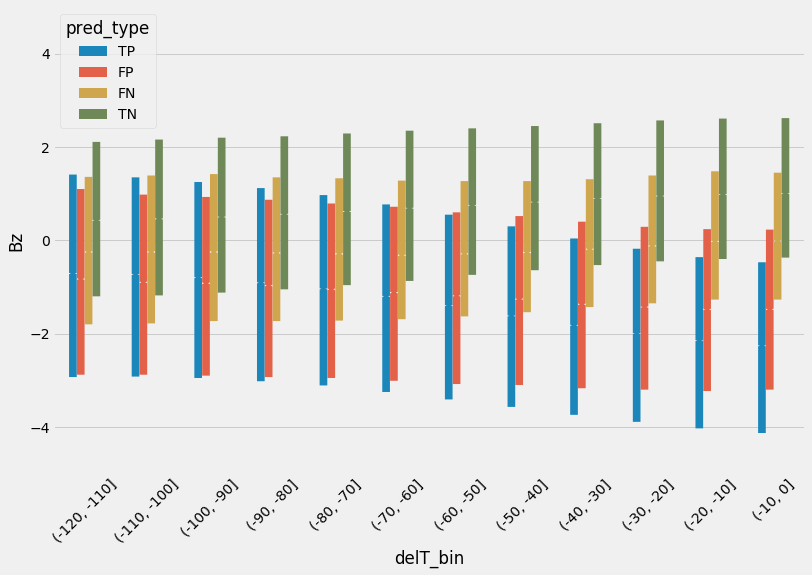

In [6]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.boxplot(x="delT_bin", y="Bz", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, showfliers=False,ax=ax, linewidth=0.,\
            notch=True, width=0.5)

ax.set_ylim([-5,5])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps")

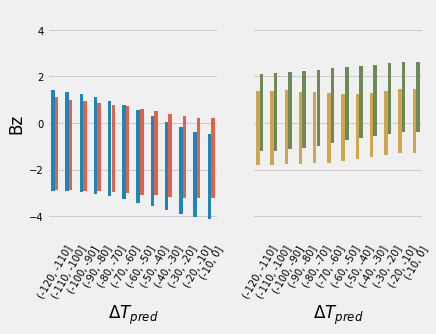

In [7]:
plt.style.use("fivethirtyeight")
predTypeList1 = [ "TP", "FP" ]
predTypeList2 = [ "FN", "TN" ]
f = plt.figure()
f, axArr = plt.subplots(nrows=1, ncols=2, sharey=True)

sns.boxplot(x="delT_bin", y="Bz", hue="pred_type", hue_order=predTypeList1,\
                  data=predDF2, showfliers=False,ax=axArr[0], linewidth=0.,\
            width=0.5)

my_pal = {"FN": "#e5ae38", "TN": "#6d904f"}
sns.boxplot(x="delT_bin", y="Bz", hue="pred_type", hue_order=predTypeList2,\
                  data=predDF2, showfliers=False,ax=axArr[1], linewidth=0.,\
            width=0.5, palette=my_pal)

for _ax in axArr:
    _ax.tick_params(labelsize=10)
    _ax.legend_.remove()
    _ax.set_xlabel(r'$\Delta T_{pred}$')
    _ax.set_ylim([-5,5])
    
axArr[1].set_ylabel("")

plt.setp( axArr[0].xaxis.get_majorticklabels(), rotation=60 )
plt.setp( axArr[1].xaxis.get_majorticklabels(), rotation=60 )

f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf", bbox_inches='tight')
f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps", bbox_inches='tight')

In [8]:
# plt.style.use("fivethirtyeight")
# predTypeList = [ "TP", "FP" ]
# f = plt.figure(figsize=(12, 8))
# ax = f.add_subplot(1,1,1)

# sns.lineplot(x="delTimeOnset", y="Bz", hue="pred_type", hue_order=predTypeList,\
#                   data=predDF2, ci="sd", ax=ax)

# ax.set_ylim([-8,8])
# plt.xticks(rotation=45)
# f.savefig("../plots/epoch_pred_types_Bz_boxplot.pdf")
# f.savefig("../plots/epoch_pred_types_Bz_boxplot.eps")

In [9]:
# plt.style.use("fivethirtyeight")
# predTypeList1 = [ "TP", "FP" ]
# predTypeList2 = [ "FN", "TN" ]
# f = plt.figure(figsize=(12, 8))
# f, axArr = plt.subplots(nrows=1, ncols=2, sharey=True)

# selDF = predDF2[ predDF2["delTimeOnset"] <= 0. ]

# sns.lineplot(x="delTimeOnset", y="Bz", hue="pred_type", hue_order=predTypeList1,\
#                   data=selDF, ax=axArr[0],\
#              estimator=numpy.median, ci="sd")
# my_pal = {"FN": "#e5ae38", "TN": "#6d904f"}
# sns.lineplot(x="delTimeOnset", y="Bz", hue="pred_type", hue_order=predTypeList2,\
#                   data=selDF, ax=axArr[1], palette=my_pal,\
#              estimator=numpy.median)

# for _ax in axArr:
#     _ax.tick_params(labelsize=10)
#     _ax.legend_.remove()
#     _ax.set_xlabel(r'$\Delta T_{pred}$')
#     _ax.set_ylim([-5,5])
    
# axArr[1].set_ylabel("")

# # axArr[0].set_ylim([-8,8])
# # axArr[1].set_ylim([-8,8])


# plt.xticks(rotation=45)
# f.savefig("../plots/epoch_pred_types_Bz_spread.pdf", bbox_inches='tight')
# f.savefig("../plots/epoch_pred_types_Bz_spread.eps", bbox_inches='tight')

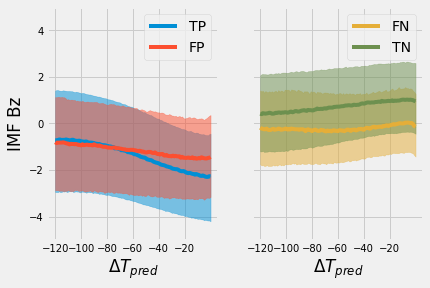

In [12]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_



f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(nrows=1, ncols=2, sharey=True)

selDF = predDF2[ predDF2["delTimeOnset"] <= 0. ]
# Compute the min, mean and max (could also be other values)
grouped = selDF.groupby(["pred_type", "delTimeOnset"]\
                       ).agg({'Bz': [percentile(25), numpy.median, percentile(75)]}\
                            ).unstack("pred_type")
# # Plot with sublot since it is more readable
# axes = grouped.loc[:,('Bz', 'median')].plot(subplots=True)

# Getting the color palette used
palette = sns.color_palette()

# Initializing an index to get each cluster and each color
predTypes = [ "TP", "FP", "FN", "TN" ]
for _ind, _ax in enumerate(axArr):
    # 1st plot
    # boundaries
    _ax.fill_between(grouped.index, grouped.loc[:,('Bz', 'median', predTypes[_ind*2])], 
                    grouped.loc[:,('Bz', 'percentile_75', predTypes[_ind*2] )],\
                    alpha=.5, color=palette[_ind*2])
    _ax.fill_between(grouped.index, 
                    grouped.loc[:,('Bz', 'percentile_25', predTypes[_ind*2])] ,\
                    grouped.loc[:,('Bz', 'median', predTypes[_ind*2])],\
                    alpha=.5, color=palette[_ind*2])
    # median
    _ax.plot( grouped.index,grouped.loc[:,('Bz', 'median', predTypes[_ind*2])],\
                    color=palette[_ind*2], label=predTypes[_ind*2]  )
    # 2nd plot
    # boundaries
    _ax.fill_between(grouped.index, grouped.loc[:,('Bz', 'median', predTypes[_ind*2+1])], 
                    grouped.loc[:,('Bz', 'percentile_75', predTypes[_ind*2+1] )],\
                    alpha=.5, color=palette[_ind*2+1])
    _ax.fill_between(grouped.index, 
                    grouped.loc[:,('Bz', 'percentile_25', predTypes[_ind*2+1])] ,\
                    grouped.loc[:,('Bz', 'median', predTypes[_ind*2+1])],\
                    alpha=.5, color=palette[_ind*2+1])
    # median
    _ax.plot( grouped.index,grouped.loc[:,('Bz', 'median', predTypes[_ind*2+1])],\
                    color=palette[_ind*2+1], label=predTypes[_ind*2+1]  )
    
    _ax.tick_params(labelsize=10)
    _ax.legend()
    _ax.xaxis.set_ticks(numpy.arange(-120, 0, 20))
    _ax.set_xlabel(r'$\Delta T_{pred}$')
    _ax.set_ylim([-5,5])
    
axArr[0].set_ylabel("IMF Bz")    
axArr[1].set_ylabel("")    
f.savefig("../plots/epoch_pred_types_Bz_spread.png", bbox_inches='tight')
f.savefig("../plots/epoch_pred_types_Bz_spread.eps", bbox_inches='tight')

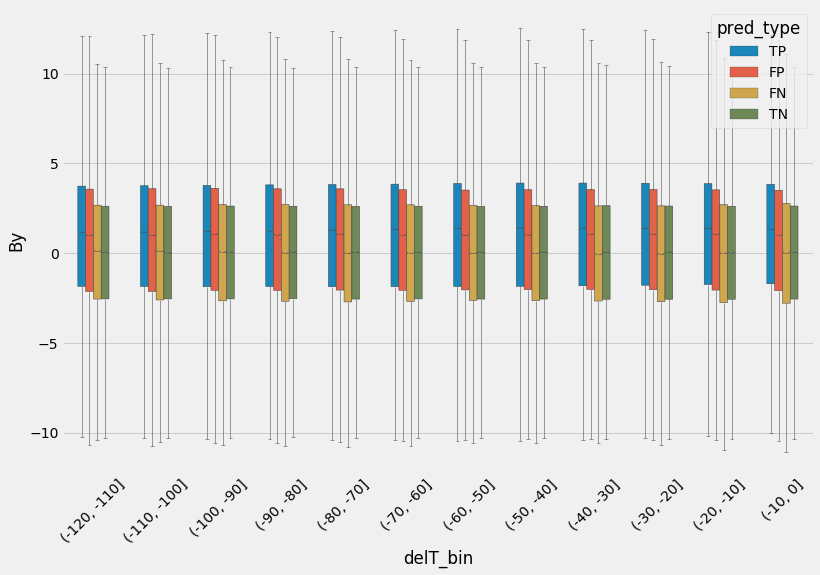

In [11]:
plt.style.use("fivethirtyeight")
predTypeList = [ "TP", "FP", "FN", "TN" ]
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

sns.boxplot(x="delT_bin", y="By", hue="pred_type", hue_order=predTypeList,\
                  data=predDF2, showfliers=False,ax=ax, linewidth=0.5,\
            notch=True, width=0.5)

# ax.set_ylim([-5,2])
plt.xticks(rotation=45)
f.savefig("../plots/epoch_pred_types_By_boxplot.pdf")
f.savefig("../plots/epoch_pred_types_By_boxplot.eps")